In [35]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [153]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[50, 100],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise
    
    def get_bounds(self, i):
        if i == 0:
            return self.inj_limits
        elif i==1:
            return self.mid_limits
        elif i==2:
            return self.ext_limits
    
    def _rescale_output(self, output):
        """himmelblau4 returns values betwen 0 and 4899 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 4899) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._himmelblau4(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _himmelblau4(w, x, y):
        """A funky 4 dimensional parameter space with a bunch of local minima."""
        return (
            (w**2 + x + y - 11)**2 +
            (w + x**2 + y - 7)**2 +
            (w + x + y**2 - 5)**2 + 0.1 * x
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [367]:
venus = Venus(jitter=0.0)

set the currents and read the beam value

In [368]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

49.99387630128598


if currents are outside the range a `ValueError` is raised and can be captured.

In [369]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [370]:
venus._himmelblau4(6, 6, 6)

4899.6

# Bayesian Optimization

In [371]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=0.05)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  90.43    |  178.8    |  153.6    |  144.4    |
|  2        |  99.94    |  182.0    |  151.3    |  141.1    |
|  3        |  98.53    |  177.0    |  148.9    |  137.6    |
|  4        |  96.73    |  175.7    |  147.8    |  139.4    |
|  5        |  97.95    |  179.8    |  153.7    |  140.3    |
|  6        |  98.83    |  180.9    |  151.0    |  139.4    |
|  7        |  94.93    |  184.5    |  152.5    |  139.6    |
|  8        |  99.38    |  181.5    |  149.4    |  141.3    |
|  9        |  96.6     |  183.7    |  149.6    |  143.2    |
|  10       |  97.42    |  180.3    |  147.8    |  138.8    |
|  11       |  98.62    |  177.9    |  151.9    |  137.1    |
|  12       |  88.25    |  175.6    |  150.5    |  135.0    |
|  13       |  98.25    |  178.3    |  150.5    |  139.3    |
|  14       |  97.47    |  180.0    |  153.4    |  137.2    |
|  15   

In [372]:
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    rand_adder = int(rand_adder)
    results = []
    coords = []
    
    for i in tqdm(range(N)):
        
        pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        noise = max(venus.get_noise_level(), 1e-5)
        # print("noise", noise)
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0,
                                         random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=2*noise**2) # , alpha=0.01
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.scatter([182.5], [151.7], s=180, marker="*") # , [140.0]
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))    

## Simple Trial

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]

Best result: {'A': 182.95735367173887, 'B': 148.68417736194704, 'C': 141.79048804360787}; f(x) = 99.9136793690932.


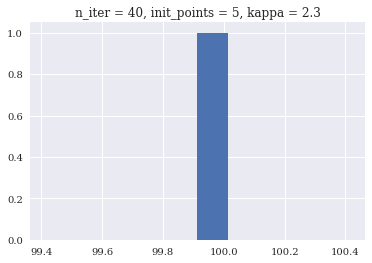

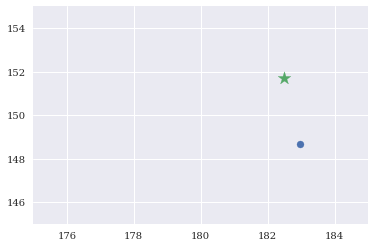

[99.9136793690932]


In [391]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

100%|███████████████████████████████████████████| 20/20 [00:41<00:00,  2.09s/it]


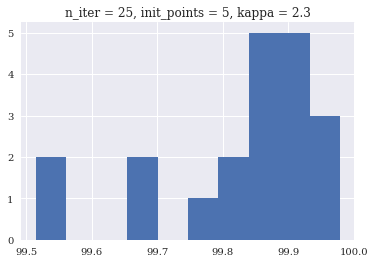

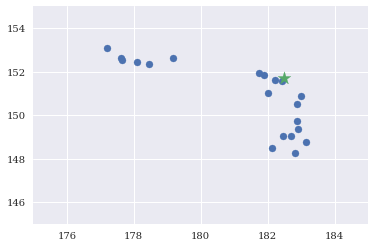

[99.9792480900727, 99.96582209543129, 99.9633202610919, 99.92757138597491, 99.92337832103132, 99.91737990964407, 99.90071104124831, 99.89555302709455, 99.8863091349613, 99.865234914085, 99.85668383731033, 99.85538347953477, 99.84972888990464, 99.83634430717117, 99.7994169108583, 99.76220870940838, 99.68766935084872, 99.65762781012259, 99.53119342348302, 99.5147411957821]


In [389]:
trial(20, n_iter = 25, init_points = 5, kappa = 2.3, verbose = 1)

100%|███████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


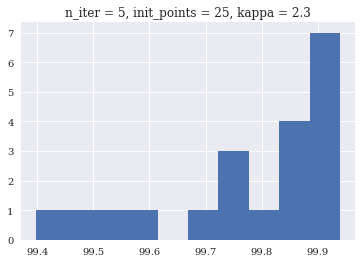

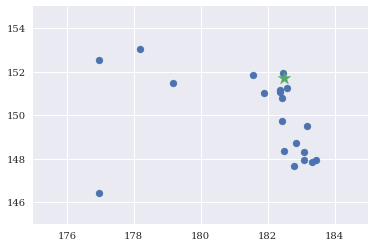

[99.93998850610308, 99.93402297489335, 99.93014079794331, 99.92138532993744, 99.91488340932587, 99.91015320763084, 99.90691499812098, 99.88165309155474, 99.86837268111756, 99.85589864924937, 99.8421140905245, 99.79813415851218, 99.77235883889516, 99.7434634824113, 99.73575135145914, 99.70675628651836, 99.56961073624386, 99.5560557330478, 99.4603576398876, 99.3972990401049]


In [390]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(20, n_iter = 5, init_points = 25, kappa = 2.3, verbose = 1, rand_adder = 2e2)

## Trying out kappa

100%|███████████████████████████████████████████| 30/30 [00:24<00:00,  1.23it/s]


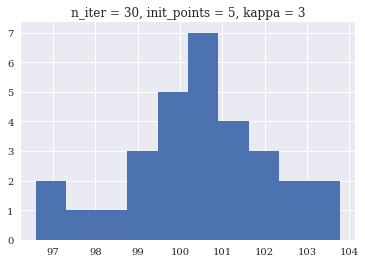

[(103.78630097046495, {'A': 180.4215157264712, 'B': 146.95083825414247, 'C': 136.8915384195574}), (103.14109282758335, {'A': 183.50618100927403, 'B': 147.92541176553416, 'C': 137.2308852664275}), (102.98874513657204, {'A': 179.7227383903856, 'B': 147.99312916695555, 'C': 142.50110577977185}), (102.73042467472361, {'A': 175.07530120928465, 'B': 145.25493168088036, 'C': 135.6366353695507}), (102.17955156737506, {'A': 178.1647203707332, 'B': 148.61733168776314, 'C': 139.5072242838262}), (102.13551988555076, {'A': 177.69362476444493, 'B': 153.09691555098163, 'C': 137.3830983604036}), (101.85843759609872, {'A': 183.11240527512467, 'B': 148.36872025924038, 'C': 137.04836025195118}), (101.60626357006733, {'A': 182.97372080817357, 'B': 150.64596273075637, 'C': 142.35550273587535}), (101.49264609743254, {'A': 179.0858720403318, 'B': 151.95642669113585, 'C': 141.23354192867885}), (101.30045967426497, {'A': 179.5640574273857, 'B': 148.1727955782775, 'C': 143.90526848327212}), (101.03102455109135,

In [138]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1, rand_adder = 5e2)

100%|███████████████████████████████████████████| 30/30 [01:16<00:00,  2.56s/it]


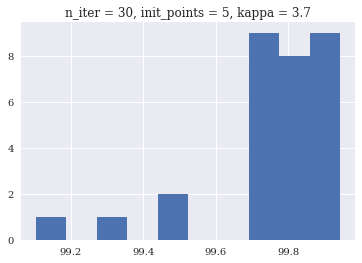

[99.9440806968612, 99.93415292603405, 99.92563341256914, 99.9170920822363, 99.89290512323879, 99.89229629503043, 99.89023030162332, 99.86961217254424, 99.86116527045309, 99.85802912167102, 99.85692488504438, 99.85134043318678, 99.81697720471885, 99.80215312267578, 99.80211940436965, 99.79504477378475, 99.7871645915383, 99.7723427358491, 99.76366173574179, 99.75901161017849, 99.75727933324521, 99.75574420862179, 99.73296480801542, 99.72743586371831, 99.70538905992692, 99.70347610980538, 99.52300426218625, 99.48721672745968, 99.32685444996844, 99.10299493816234]


In [39]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1, rand_adder = 7e2)

100%|███████████████████████████████████████████| 30/30 [01:21<00:00,  2.71s/it]


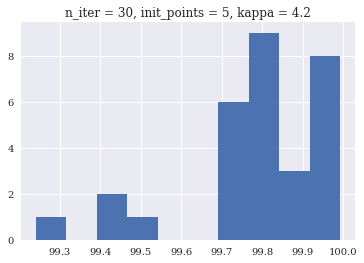

[99.99282846986006, 99.97597157526137, 99.97381887913336, 99.95848251715611, 99.94669809402147, 99.94349666436293, 99.9323005851941, 99.91785678733544, 99.91049550864764, 99.90759234051518, 99.90600535622806, 99.82615429735219, 99.82523947059997, 99.8173288808542, 99.80632711068418, 99.78293490685765, 99.78235714668465, 99.78221976778241, 99.76976637516661, 99.76716684035767, 99.75288044370397, 99.74672888477299, 99.73483897857535, 99.73336252745008, 99.72601180202874, 99.7061224741984, 99.5202214527682, 99.46140461983055, 99.44285337592964, 99.24061662979827]


In [40]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 8e2)

100%|███████████████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]


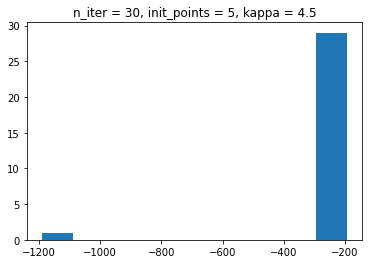

In [118]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1, rand_adder = 9e2)

## Increase n_iter

100%|███████████████████████████████████████████| 30/30 [04:09<00:00,  8.30s/it]


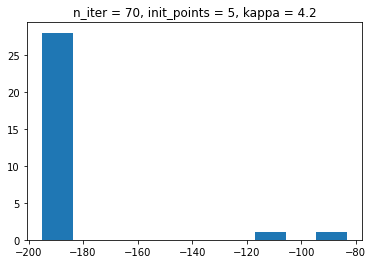

[-83.41717482507394, -108.00906940923039, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [130]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1, rand_adder = 1e3)

100%|███████████████████████████████████████████| 30/30 [04:24<00:00,  8.83s/it]


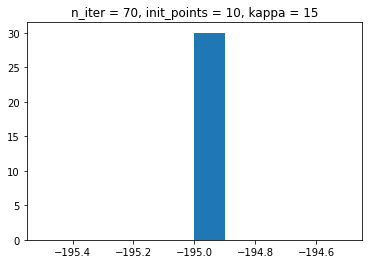

[-195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0]


In [142]:
trial(30, n_iter = 70, init_points = 10, kappa = 15, verbose = 1, rand_adder = 1.1e3)

100%|███████████████████████████████████████████| 30/30 [04:37<00:00,  9.25s/it]


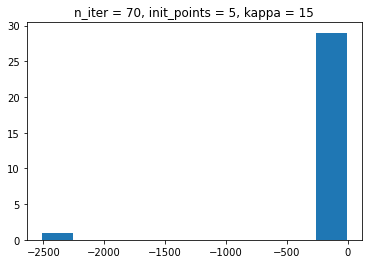

[-9.460997841425904, -194.99999999999991, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -195.0, -2510.300282621165]


In [137]:
trial(30, n_iter = 70, init_points = 5, kappa = 15, verbose = 1, rand_adder = 1.2e3)

In [ ]:
# TODO: guide optimization to known good points

In [65]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [66]:
# ackley_arg0((0,0,0))

In [ ]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2